In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina' # I use a HiDPI screen

In [2]:
from fishchips.experiments import CMB_Primary
from fishchips.cosmo import Observables
import fishchips.cmb_lensing
import fishchips.util

from classy import Class  # CLASS python wrapper
import numpy as np
import matplotlib.pyplot as plt
default_color_list = ['#1A1A1A', '#0072B2', '#009E73', '#D55E00', '#CC79A7', '#F0E442', '#56B4E9']

# Reproducing Figure 4 of Allison+2015

We reproduce Figure 4 of https://arxiv.org/abs/1509.07471. We seem to consistently overestimate by ~20\%, which might be due to Boltzmann code settings. To use the lensing module, you need `orphics` and `enlib`.

First, let's set up our template CLASS dictionary, and the fiducial/stepsizes for Fisher.

In [3]:
# create an Observables object to store information for derivatives
pars = np.array( ['omega_b', 'omega_cdm', 'h',  'A_s', 'n_s', 'tau_reio', 'sum_mnu'])
centers = np.array([0.02222,  0.1197,  0.69,  2.1955e-9, 0.9655, 0.06, 0.06])
left_steps = np.array([0.0008, 0.003,   0.02,   0.1e-9, 0.01, 0.02, 0.0])
right_steps = np.array([0.0008, 0.003,   0.02,   0.1e-9, 0.01, 0.02, 0.02])

obs = Observables(parameters=pars,
                  fiducial=centers,
                  left=centers-left_steps,
                  right=centers+right_steps)

# generate a template CLASS python wrapper configuration
classy_template = {'output': 'tCl pCl lCl mPk',
                   'l_max_scalars': 5000,
                   'lensing': 'yes',
                   
                 'reionization_optical_depth_tol': 1e-07,
                 'tol_background_integration': 1e-8,
                 'tol_perturb_integration': 1e-8,
                 'tol_thermo_integration': 1e-8,
              
                 'perturb_sampling_stepsize':0.01,
                 'k_max_tau0_over_l_max' : 6,
                   
                  'P_k_max_1/Mpc':3.0}
# classy_template.update(fishchips.util.PRECISE_CLASS_DICT)

# add in the fiducial values too
classy_template.update(dict(zip(obs.parameters, obs.fiducial)))

Now we generate the cosmologies. Note the use of the `fishchips.util.neutrino_dict()` function, which turns `sum_mnu` into the appropriate sum of neutrino species.

In [4]:
# generate the fiducial cosmology
obs.compute_cosmo(key='CLASS_fiducial',
                  classy_dict=fishchips.util.neutrino_dict(classy_template))

# generate an observables dictionary, looping over parameters
for par, par_left, par_right in zip(obs.parameters, obs.left, obs.right):
    classy_left = classy_template.copy()
    classy_left[par] = par_left
    classy_right = classy_template.copy()
    classy_right[par] = par_right
    # pass the dictionaries full of configurations to get computed
    obs.compute_cosmo(key=par + '_CLASS_left',
                      classy_dict=fishchips.util.neutrino_dict(classy_left))
    obs.compute_cosmo(key=par + '_CLASS_right',
                      classy_dict=fishchips.util.neutrino_dict(classy_right))

We create `fishchips.Experiment` objects for Planck, S3, and S4.

In [5]:
Allison_Planck = [fishchips.experiments.CMB_Primary(l_min=2, 
                                                l_max=2500, f_sky=0.44),
                     fishchips.cmb_lensing.CMB_Lensing_Only(lens_kmax=2000, 
                                                            lens_tellmax=2500, 
                                                            lens_pellmax=2500, 
                                                            lens_f_sky=0.44)]

Generating theory Cls...
Loaded cached Cls from  output/clsAll_low_acc_False_3500_20180817.pkl
Loaded cached Cls from  output/clphi_low_acc_False_3500_20180817.txt


In [6]:
Allison_S3 = [fishchips.experiments.CMB_Primary(l_min=50, l_max=3000,
                theta_fwhm=(1.4,), sigma_T=(8.0,), 
                sigma_P=(11.3,), f_sky=0.4),
              fishchips.experiments.CMB_Primary(l_min=3000, l_max=4000,
                theta_fwhm=(1.4,), sigma_T=(1e100,),
                sigma_P=(11.3,), f_sky=0.4),
              fishchips.cmb_lensing.CMB_Lensing_Only(
                lens_beam=1.4, lens_noiseT=8.0, lens_noiseP=11.3),
              fishchips.experiments.CMB_Primary(l_min=2, 
                                                l_max=50, f_sky=0.44),
              fishchips.experiments.CMB_Primary(l_min=50, 
                                                l_max=2500, f_sky=0.2)]


Generating theory Cls...
Loaded cached Cls from  output/clsAll_low_acc_False_4000_20180817.pkl
Loaded cached Cls from  output/clphi_low_acc_False_4000_20180817.txt


In [7]:
Allison_S4 = [fishchips.experiments.CMB_Primary(l_min=50, l_max=3000,
                theta_fwhm=(3.0,), sigma_T=(1.0,), 
                sigma_P=(1.4,), f_sky=0.4),
              fishchips.experiments.CMB_Primary(l_min=3000, l_max=4000,
                theta_fwhm=(3.0,), sigma_T=(1e100,),
                sigma_P=(1.4,), f_sky=0.4),
              fishchips.cmb_lensing.CMB_Lensing_Only(
                lens_beam=3.0, lens_noiseT=1.0, lens_noiseP=1.4),
              fishchips.experiments.CMB_Primary(l_min=2, 
                                                l_max=50, f_sky=0.44),
              fishchips.experiments.CMB_Primary(l_min=50, 
                                                l_max=2500, f_sky=0.2)]


Generating theory Cls...
Loaded cached Cls from  output/clsAll_low_acc_False_4000_20180817.pkl
Loaded cached Cls from  output/clphi_low_acc_False_4000_20180817.txt


We also have BAO forecasts, let's load in the errors.

In [8]:
from astropy.io import ascii
data = ascii.read("../data/BAO-2015.cat", format='commented_header')
BAO2015 = fishchips.experiments.rs_dv_BAO_Experiment(data['z'], data['error'])

data = ascii.read("../data/DESI.cat", format='commented_header')
DESI = fishchips.experiments.rs_dv_BAO_Experiment(data['z'], data['error'])

Now we just compute Fisher and make an ellipse.


0.24554808972775272

0.0887775338682134

0.07961693773954107

0.10396132752951905

0.02675707088836946

0.02363785911813913


(0.117, 0.123)

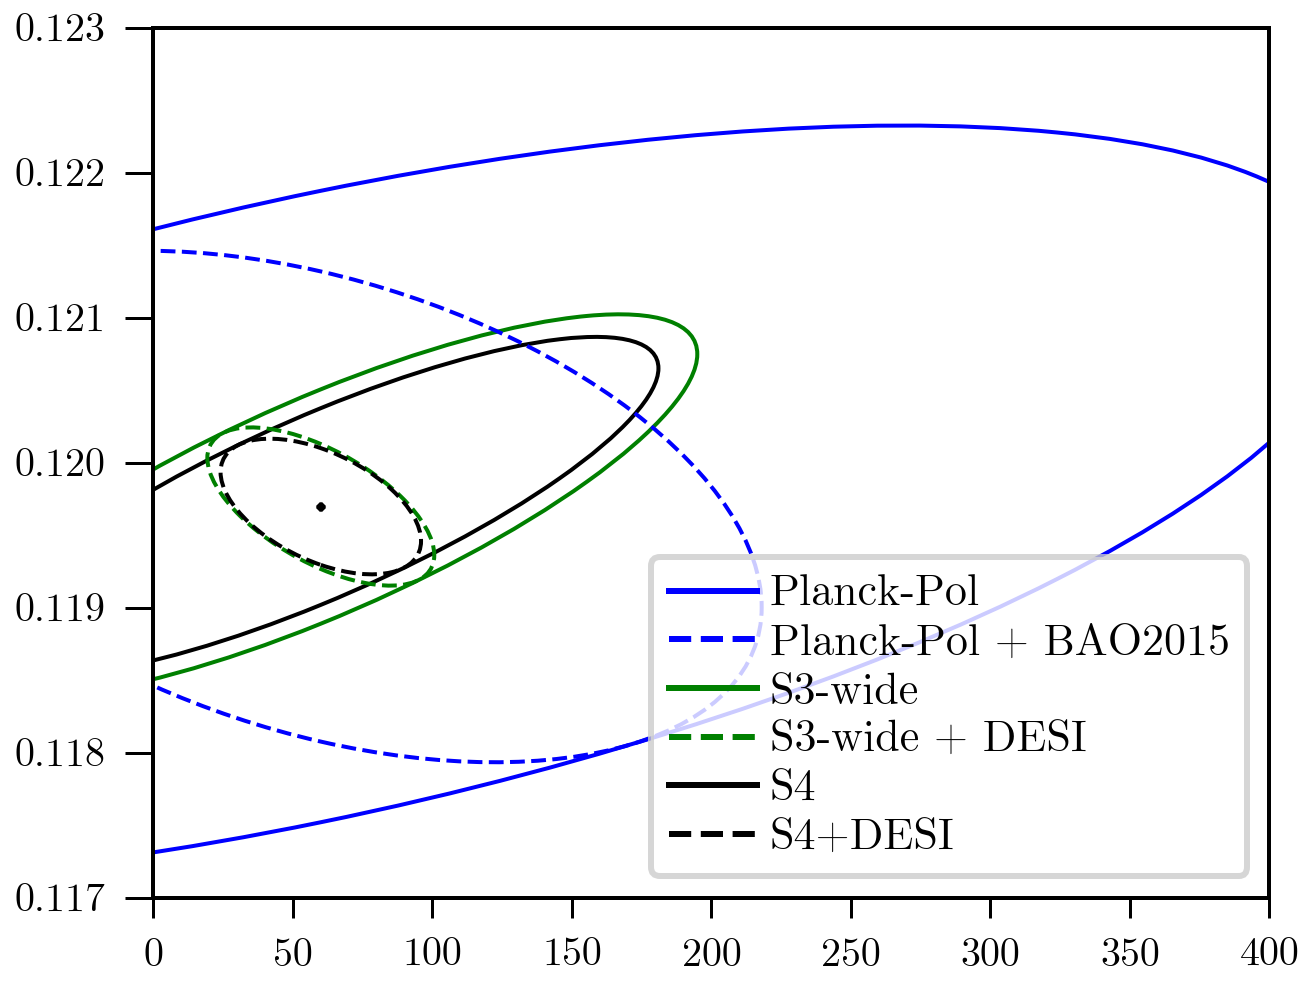

In [9]:
single_fig, single_ax = plt.subplots(figsize=(10,8))

# CMB + lensing
fisher = np.sum( [exp.get_fisher(obs, lensed_Cl=True) for exp in Allison_Planck], axis=0 )
cov = np.linalg.inv(fisher)
fishchips.util.plot_ellipse(single_ax, 'sum_mnu', 'omega_cdm', obs, cov, color="blue", one_sigma_only=True, scale1=1000, ls1='-')
print(np.sqrt(cov[-1,-1]))

fisher = np.sum( [exp.get_fisher(obs, lensed_Cl=True) for exp in Allison_S3], axis=0 )
cov = np.linalg.inv(fisher)
fishchips.util.plot_ellipse(single_ax, 'sum_mnu', 'omega_cdm', obs, cov, color="green", one_sigma_only=True, scale1=1000, ls1='-')
print(np.sqrt(cov[-1,-1]))

fisher = np.sum( [exp.get_fisher(obs, lensed_Cl=True) for exp in Allison_S4], axis=0 )
cov = np.linalg.inv(fisher)
fishchips.util.plot_ellipse(single_ax, 'sum_mnu', 'omega_cdm', obs, cov, color="black", one_sigma_only=True, scale1=1000, ls1='-')
print(np.sqrt(cov[-1,-1]))

# now BAO experiments
fisher = np.sum( [exp.get_fisher(obs, lensed_Cl=True) for exp in Allison_Planck + [BAO2015]], axis=0 )
cov = np.linalg.inv(fisher)
fishchips.util.plot_ellipse(single_ax, 'sum_mnu', 'omega_cdm', obs, cov, color="blue", one_sigma_only=True, scale1=1000, ls1='--')
print(np.sqrt(cov[-1,-1]))

fisher = np.sum( [exp.get_fisher(obs, lensed_Cl=True) for exp in Allison_S3 + [DESI]], axis=0 )
cov = np.linalg.inv(fisher)
fishchips.util.plot_ellipse(single_ax, 'sum_mnu', 'omega_cdm', obs, cov, color="green", one_sigma_only=True, scale1=1000, ls1='--')
print(np.sqrt(cov[-1,-1]))

fisher = np.sum( [exp.get_fisher(obs, lensed_Cl=True) for exp in Allison_S4 + [DESI]], axis=0 )
cov = np.linalg.inv(fisher)
fishchips.util.plot_ellipse(single_ax, 'sum_mnu', 'omega_cdm', obs, cov, color="black", one_sigma_only=True, scale1=1000, ls1='--')
print(np.sqrt(cov[-1,-1]))



# make a legend
l1, = single_ax.plot([],[],'-',color="blue")
l2, = single_ax.plot([],[],'--',color="blue")
l3, = single_ax.plot([],[],'-',color="green")
l6, = single_ax.plot([],[],'--',color="green")
l4, = single_ax.plot([],[],'-',color="black")
l5, = single_ax.plot([],[],'--',color="black")

single_ax.legend( [l1, l2,l3,l6, l4, l5], \
                    ['Planck-Pol', 'Planck-Pol + BAO2015', 
                      'S3-wide', 'S3-wide + DESI',r'S4', r'S4+DESI', ], \
              loc = 'lower right', ncol=1, frameon=True );
single_ax.plot( [60],[0.1197], 'kx')

single_ax.set_xlim(0,400)
single_ax.set_ylim(0.117, 0.123)